In [5]:
import argparse
import os
import numpy as np
from torch import optim
import torch.utils.data
import torch
from tqdm import tqdm
import torchsummary
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from Evaluator import evaluator
from loader import png_Dataset
from losses import calc_loss
from result_to_csv import result_to_csv
import shutil
import time
import yaml
import models
from mmcv.runner import load_checkpoint
import torchvision
from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Evaluate On Device: ", device)


Evaluate On Device:  cuda:0


In [6]:
parser = argparse.ArgumentParser()

parser.add_argument('--data_path_img', default="data\\Bijie\\image\\",
                    type=str, metavar='data', help='path to dataset')
parser.add_argument('--data_path_label', default="data\\Bijie\\label\\",
                    type=str, metavar='data', help='path to dataset')
parser.add_argument('-j', '--workers', default=2, type=int, metavar='N', 
                    help='number workers (default: 2)')
parser.add_argument('--shuffle', default=True, type=bool, metavar='N', 
                    help='shuffle')
parser.add_argument('-b', '--batch_size', default=2, type=int,
                    metavar='N', help='mini-batch size (default: 128)')
parser.add_argument('--valid_size', default=0.3, type=float, metavar='M',
                    help='vaildation size of total data')
parser.add_argument('--resume', default='checkpoint', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('--seed', default=42, type=int, help='seed for initializing training. ')
parser.add_argument('--config', default='translandseg.yaml')
parser.add_argument('--model', help=' path to best checkpoint of model. ')




### 一些函数
def get_data_loader(args):
    Training_Data = png_Dataset(args.data_path_img, args.data_path_label)
    num_train = len(Training_Data)
    indices = list(range(num_train))
    split = int(np.floor(args.valid_size * num_train))

    if args.shuffle:
        np.random.seed(args.seed)
        torch.manual_seed(args.seed)  
        np.random.shuffle(indices)    
        
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    if torch.cuda.is_available():
        pin_memory = True

    train_loader = torch.utils.data.DataLoader(Training_Data, batch_size=args.batch_size, sampler=train_sampler, shuffle=False,
                                            num_workers=args.workers, pin_memory=pin_memory)

    valid_loader = torch.utils.data.DataLoader(Training_Data, batch_size=args.batch_size, sampler=valid_sampler,shuffle=False,
                                            num_workers=args.workers, pin_memory=pin_memory) 
    return train_loader, valid_loader 


#预测结果可视化
def process(image):
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((1024, 1024)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
    ])
    image = transform(image)
    return image.unsqueeze(0)

def predict(model, image):
    model.eval()
    image = process(image).to(device).type(torch.cuda.FloatTensor)
    with torch.no_grad():
        result = model.infer(image)
    result = torch.sigmoid(result)     
    result = torch.where(result > 0.5, 1, 0)
    result = result.cpu().detach().numpy()
    result = result.squeeze()
    return result
def plot_contrast(data_list, title_list, camp='gray'):
    
    n = len(data_list)
    fig=plt.figure(figsize=(30,8))
    for i in range(n):
        plt.subplot(1,n,i+1)
        if data_list[i].shape[-1] == 1 or len(data_list[i].shape) == 2:
            plt.imshow(data_list[i], cmap=camp)
        else:
            plt.imshow(data_list[i])
        plt.axis('off')
        plt.title(title_list[i])
    plt.savefig(args.resume+"picture")
    plt.show()

import pandas as pd

def valuation(val_loader, model, args, save_pred_picture=False):
    model.eval()
    evaluator.reset()
    tbar = tqdm(val_loader, desc='Validation>>>>>>>')
    for i, (x,y) in enumerate(tbar):

        x.type(torch.cuda.FloatTensor)
        y.type(torch.cuda.FloatTensor)
        image, target = x.to(device), y.to(device)
        with torch.no_grad():
            output = model.infer(image)
        pred = torch.sigmoid(output)  
        pred = torch.where(pred > 0.5, 1.0, 0.0) 
        evaluator.add_batch(target, pred)
        accuracy = evaluator.OverallAccuracy()
        presion = evaluator.Precision() 
        recall = evaluator.Recall() 
        F1score = evaluator.F1Score() 
        Iou = evaluator.IntersectionOverUnion() 
        FWIou = evaluator.Frequency_Weighted_Intersection_over_Union() 
        mIou = evaluator.MeanIntersectionOverUnion()
        
        if save_pred_picture:
            for n in range(x.size(0)):
                plt.imsave(os.path.join(args.resume, 'predict_picture' ,str(i * args.batch_size + n) + '.png'), pred.cpu()[n,0,:,:], cmap="gray")

    result_dict = {'accuracy': accuracy, 'presion': presion, 'recall': recall, 'F1score': F1score, 'Iou': Iou, 'FWIou': FWIou, 'mIou': mIou}   
    return result_dict


def call_matric(result, index,out_file='matric.csv', if_show=True):
    precision = result['presion']
    recall = result['recall']
    oa = result['accuracy']
    IoU = result['Iou']
    FWIOU = result['FWIou']
    mIOU = result['mIou']
    f1score = result['F1score']
    oa= precision / precision *oa
    mIOU = precision / precision * mIOU
    FWIOU = precision / precision * FWIOU
    temp = np.column_stack((precision, recall, f1score, IoU, oa, mIOU, FWIOU))
    mean=np.mean(temp,axis=0)
    result = np.vstack((temp, mean.transpose()))
    name = ['precision','recall','F1-score','iou','oa','miou','fwiou']
    df2 = pd.DataFrame((result))
    df2.index = index
    df2.columns = name
    df2.to_csv(out_file, index=True, encoding="utf_8_sig")
    if if_show:
        print(df2)
    return result, df2



In [7]:
args = parser.parse_args(args=[])
train_loader, valid_loader = get_data_loader(args)
with open(args.config, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [8]:

# 加载模型
model = models.make(config['model']).cuda()
evaluator = evaluator(2)
checkpoint = torch.load(args.model, map_location=torch.device('cpu'))
state_dict = checkpoint['state_dict']
msg = model.load_state_dict(state_dict)
model.to(device)

# 精度测试
model.eval()
result = valuation(valid_loader, model, args, save_pred_picture=False)
call_matric(result,[1,2,'mean'], out_file="matric.csv", if_show=False)


Validation>>>>>>>: 100%|██████████| 116/116 [01:46<00:00,  1.09it/s]


(array([[0.98746931, 0.98426417, 0.98586414, 0.97212235, 0.9746119 ,
         0.87538055, 0.95267008],
        [0.86319088, 0.888257  , 0.87554457, 0.77863875, 0.9746119 ,
         0.87538055, 0.95267008],
        [0.92533009, 0.93626059, 0.93070435, 0.87538055, 0.9746119 ,
         0.87538055, 0.95267008]]),
       precision    recall  F1-score       iou        oa      miou    fwiou
 1      0.987469  0.984264  0.985864  0.972122  0.974612  0.875381  0.95267
 2      0.863191  0.888257  0.875545  0.778639  0.974612  0.875381  0.95267
 mean   0.925330  0.936261  0.930704  0.875381  0.974612  0.875381  0.95267)

qxg058.png


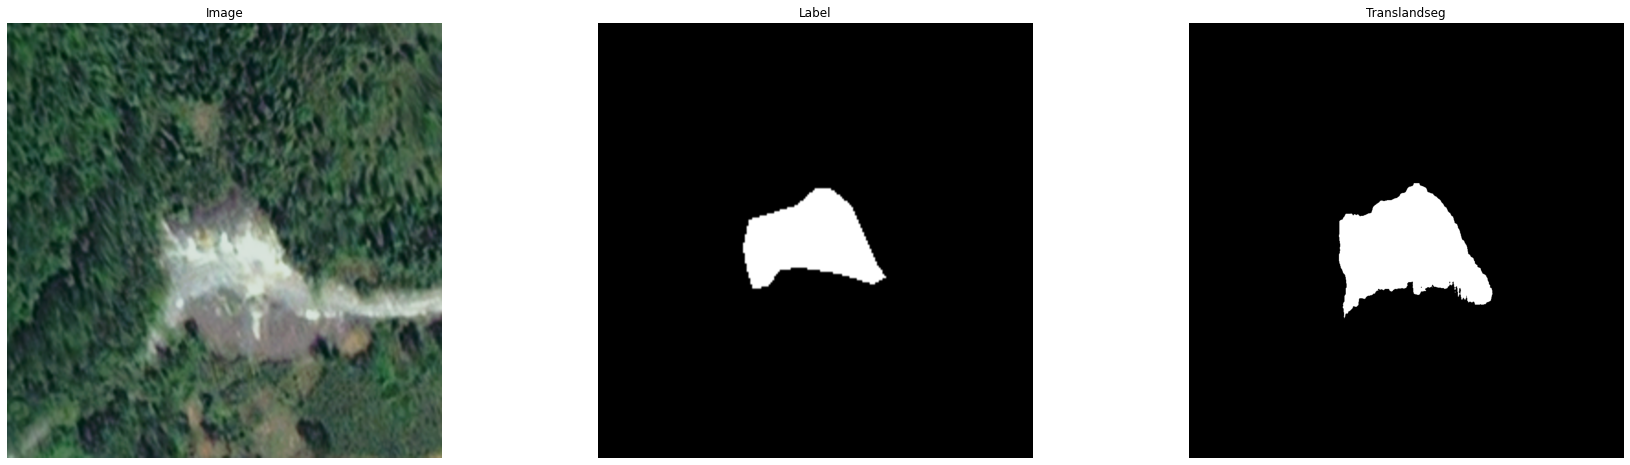

qxg094.png


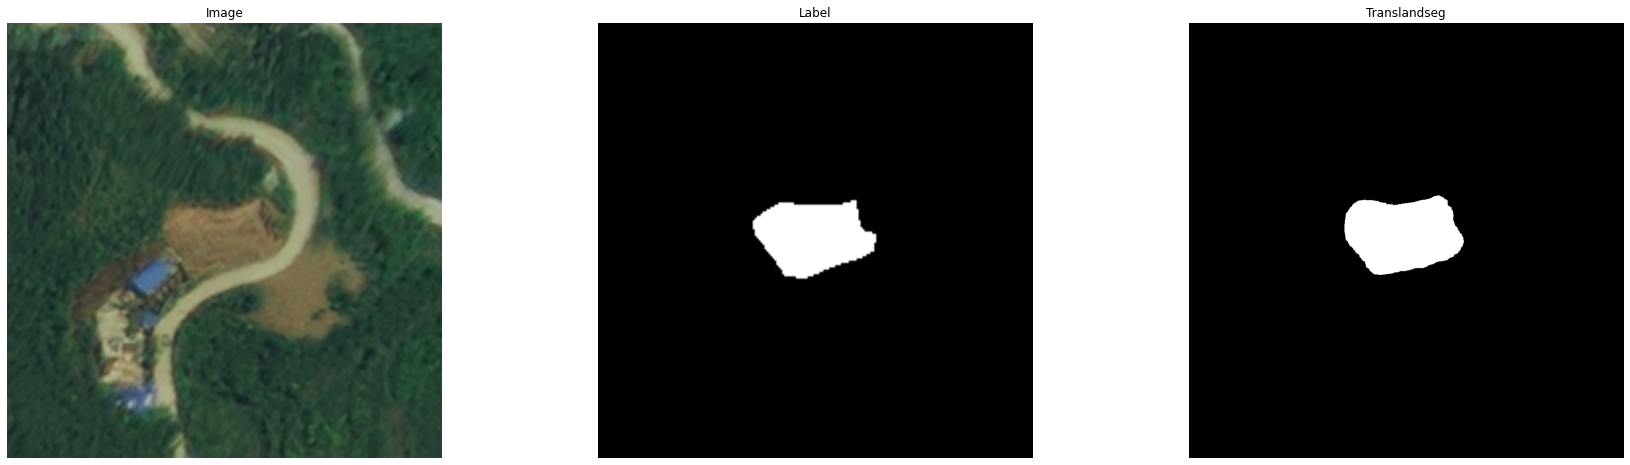

qxg076.png


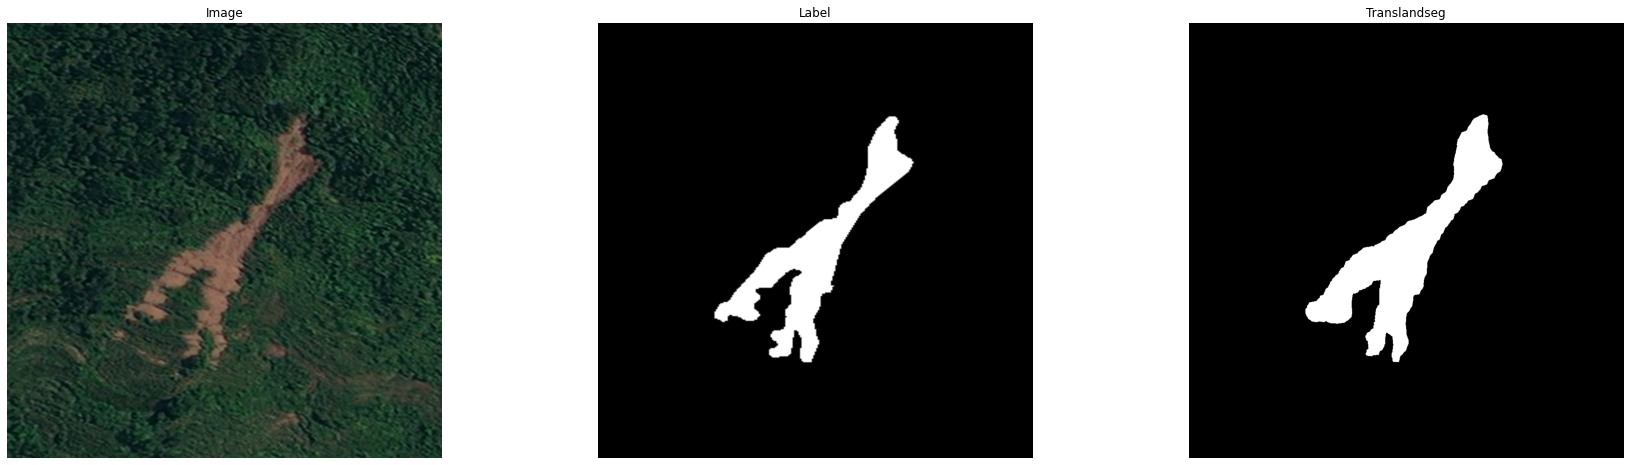

qxg067.png


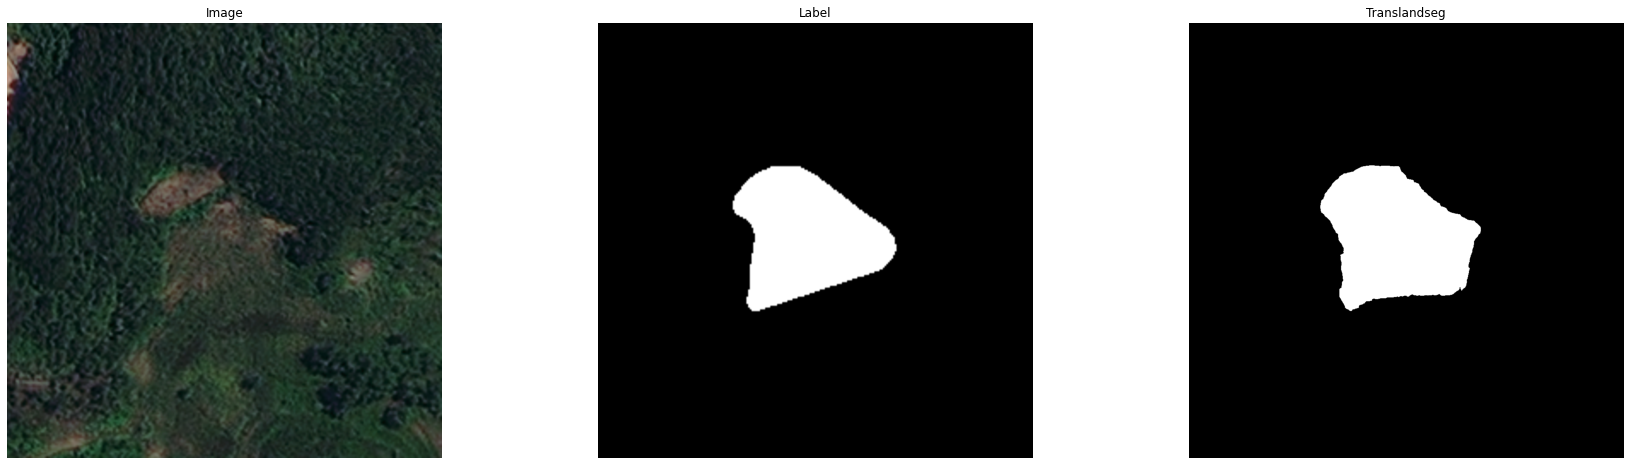

qxg085.png


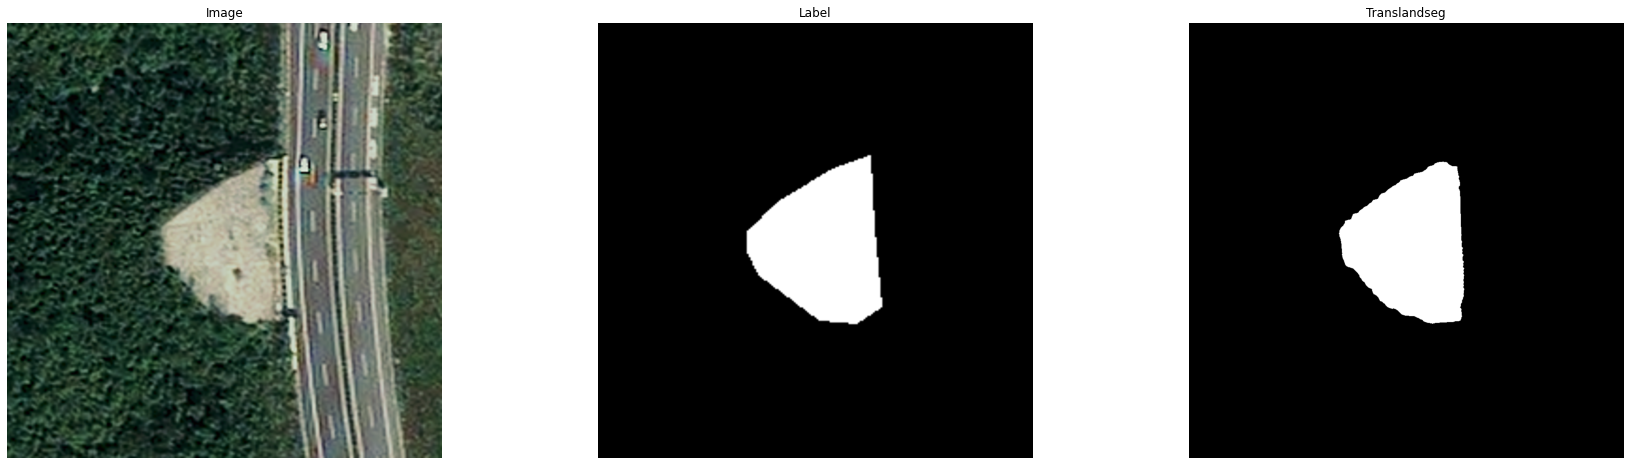

qxg049.png


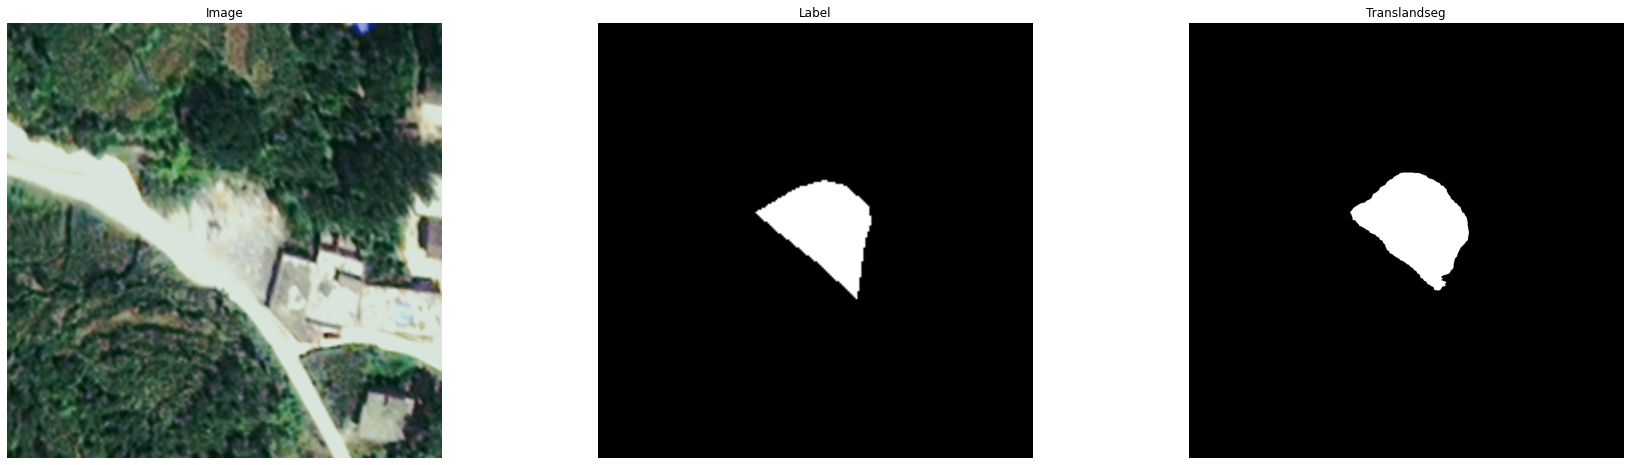

hz047.png


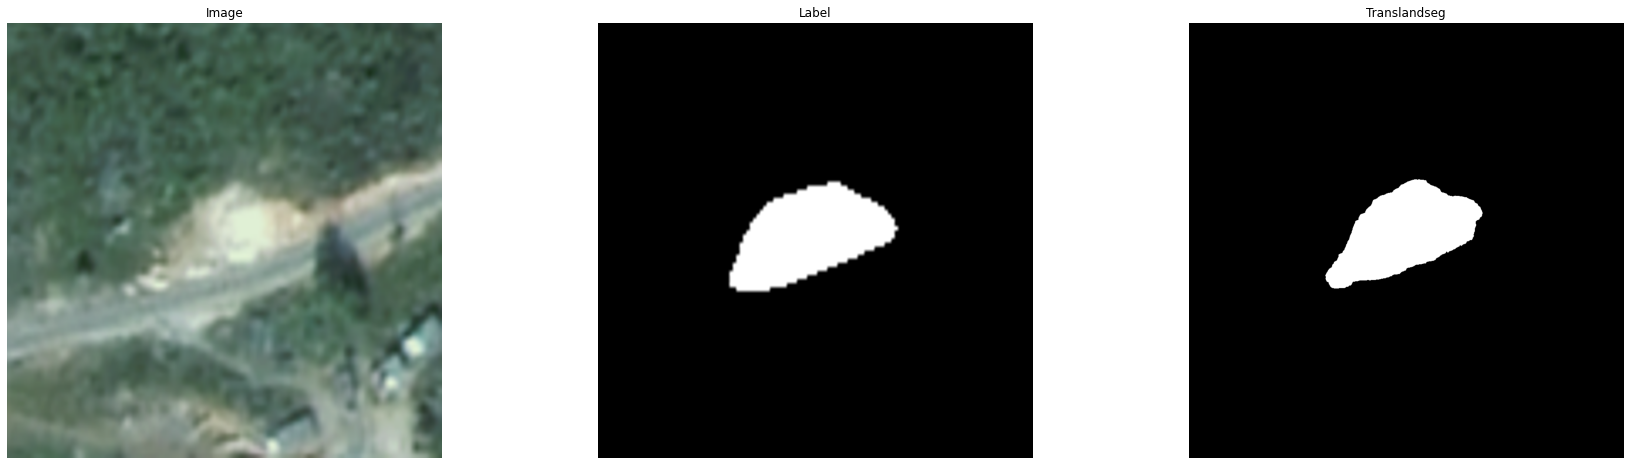

df012.png


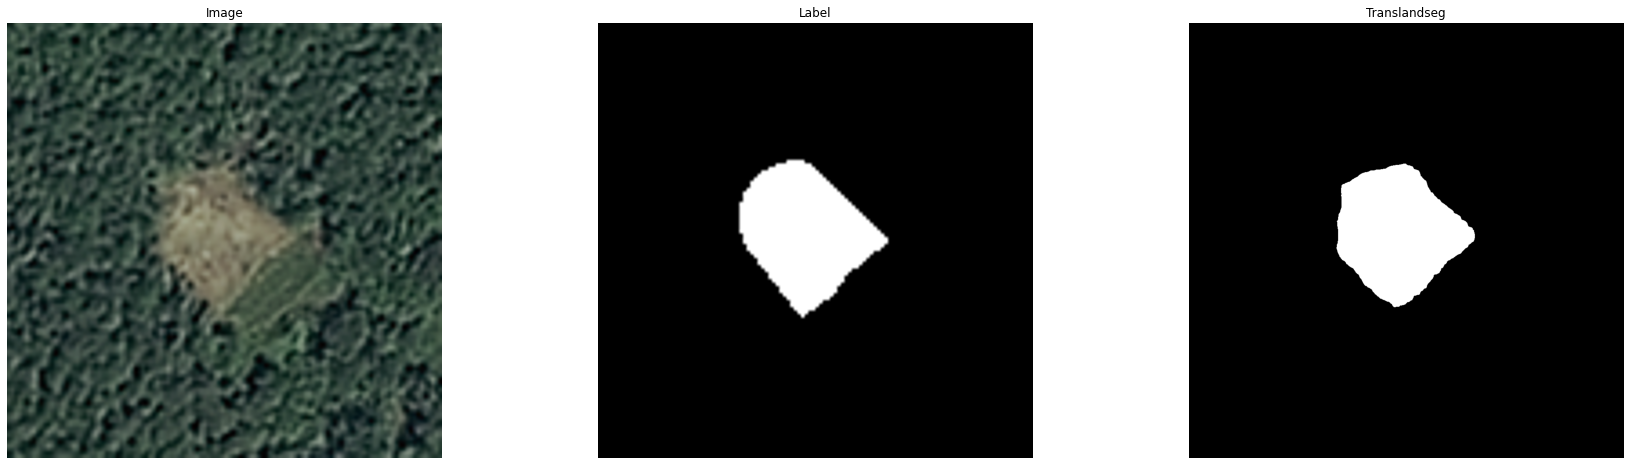

zj045.png


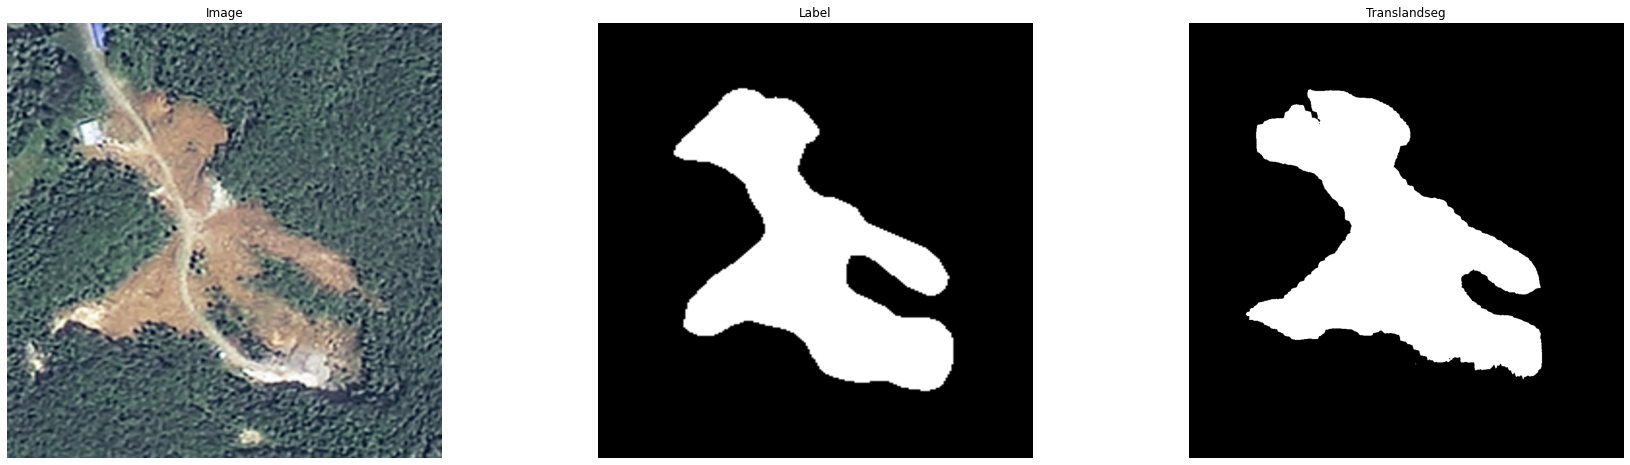

wn044.png


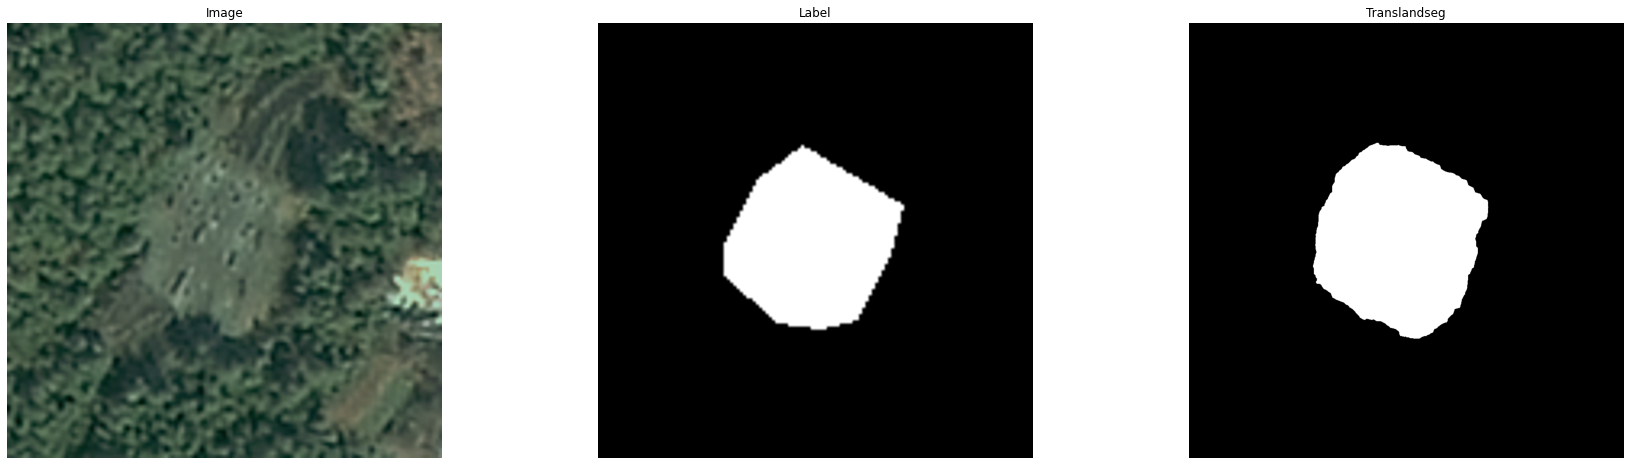

hz083.png


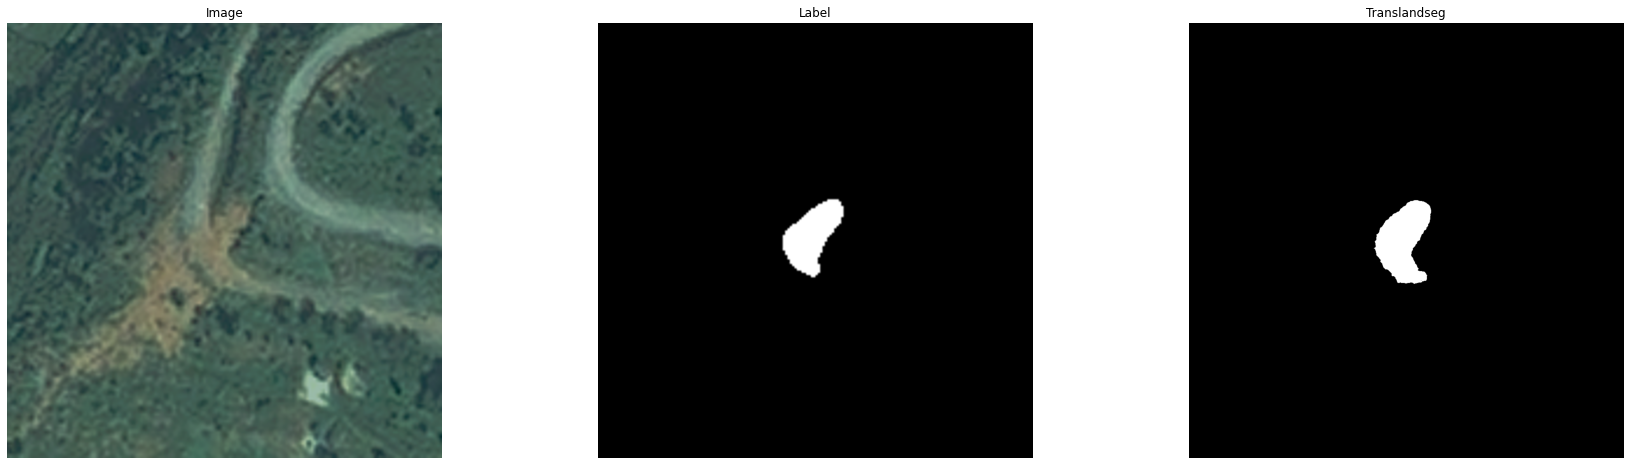

zj009.png


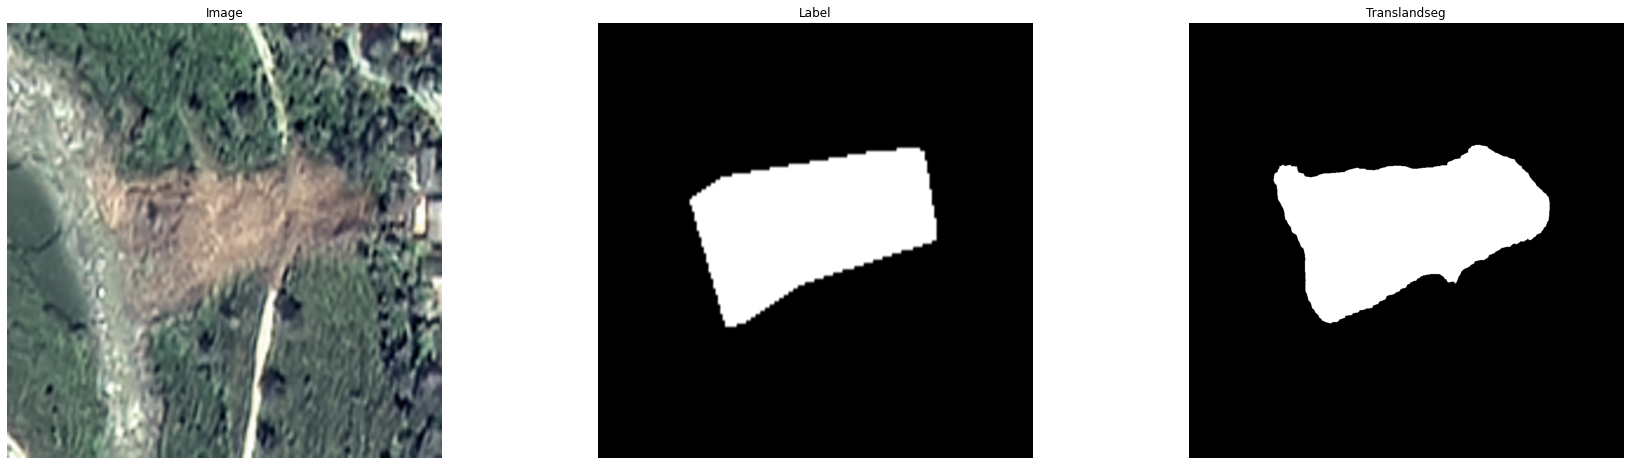

wn008.png


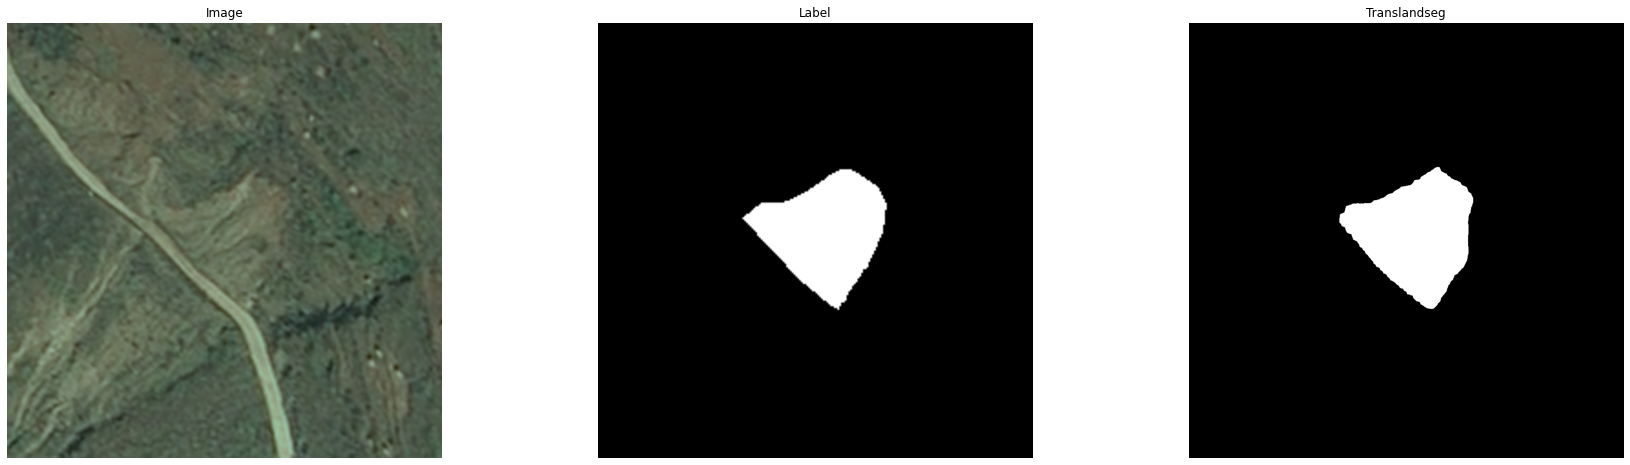

ny033.png


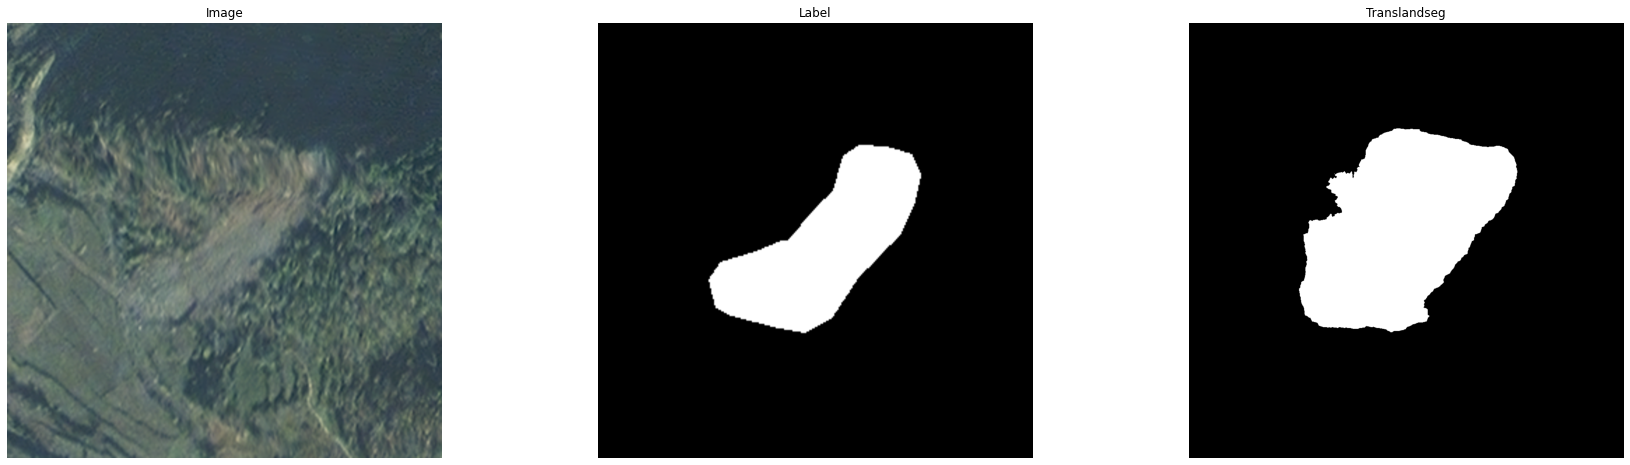

qx022.png


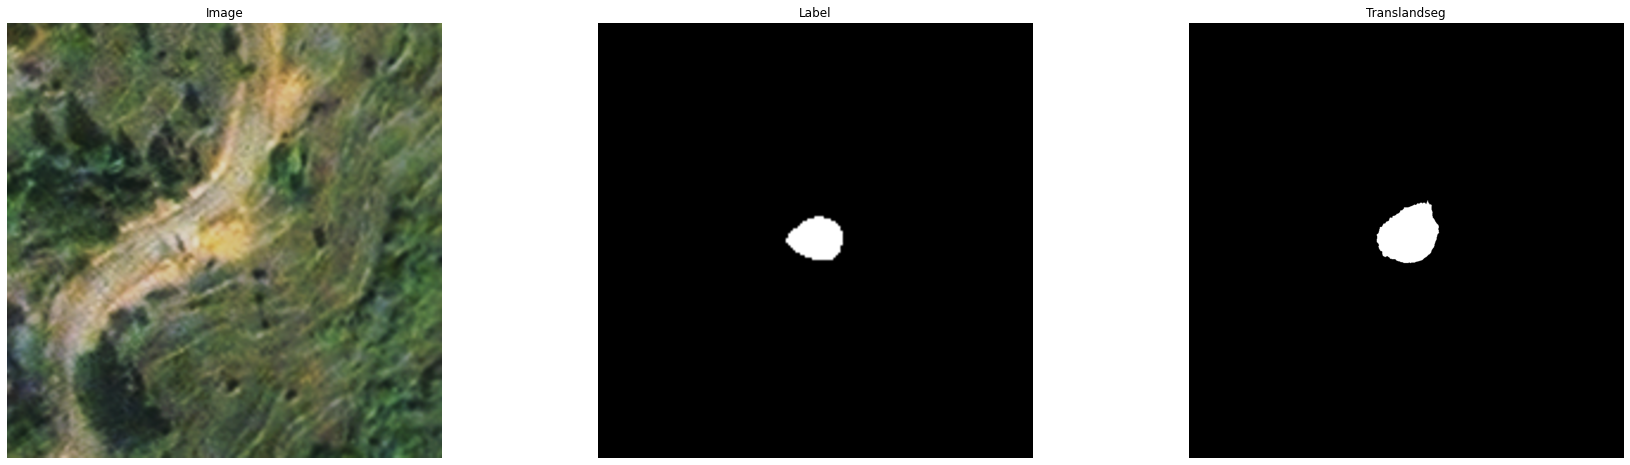

zj081.png


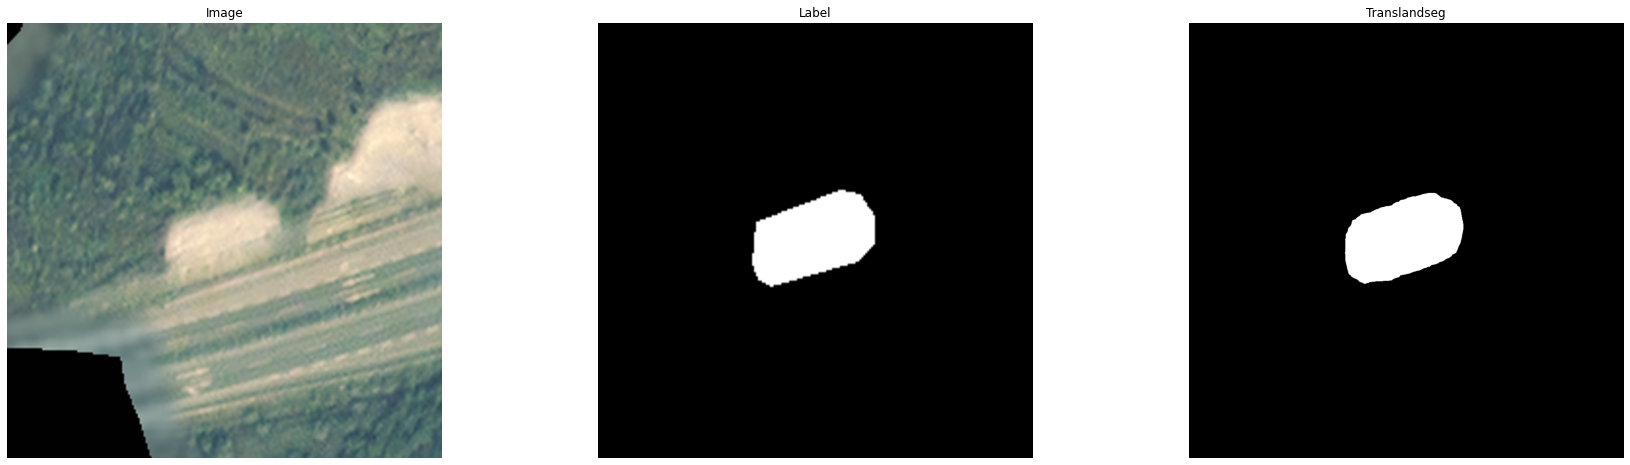

qx103.png


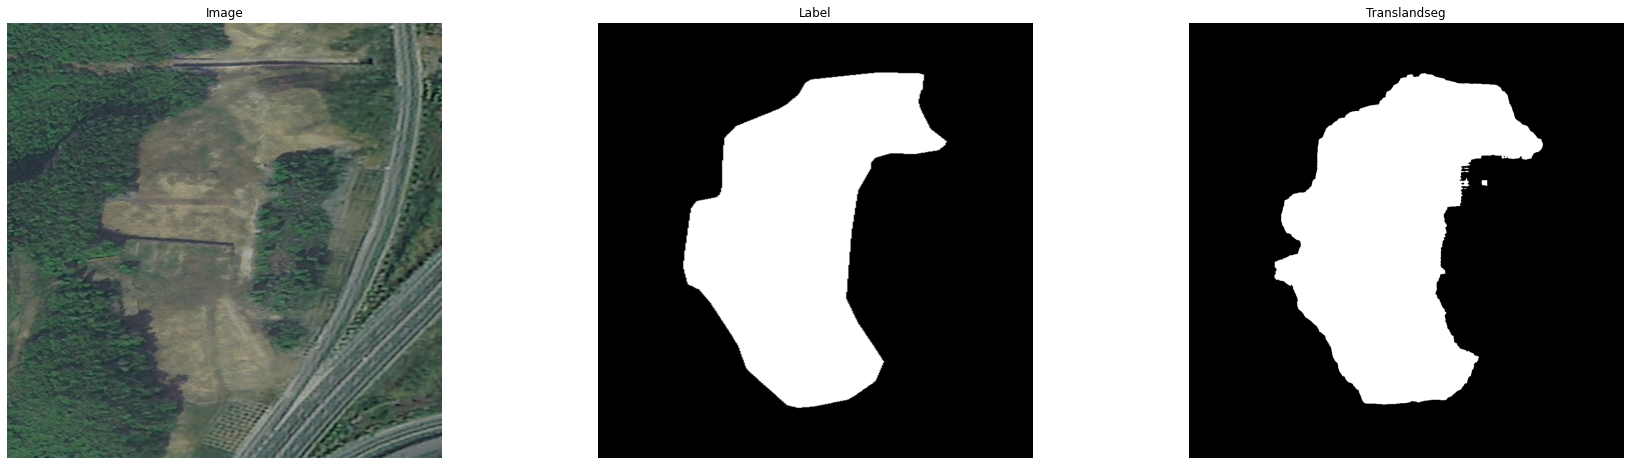

hz065.png


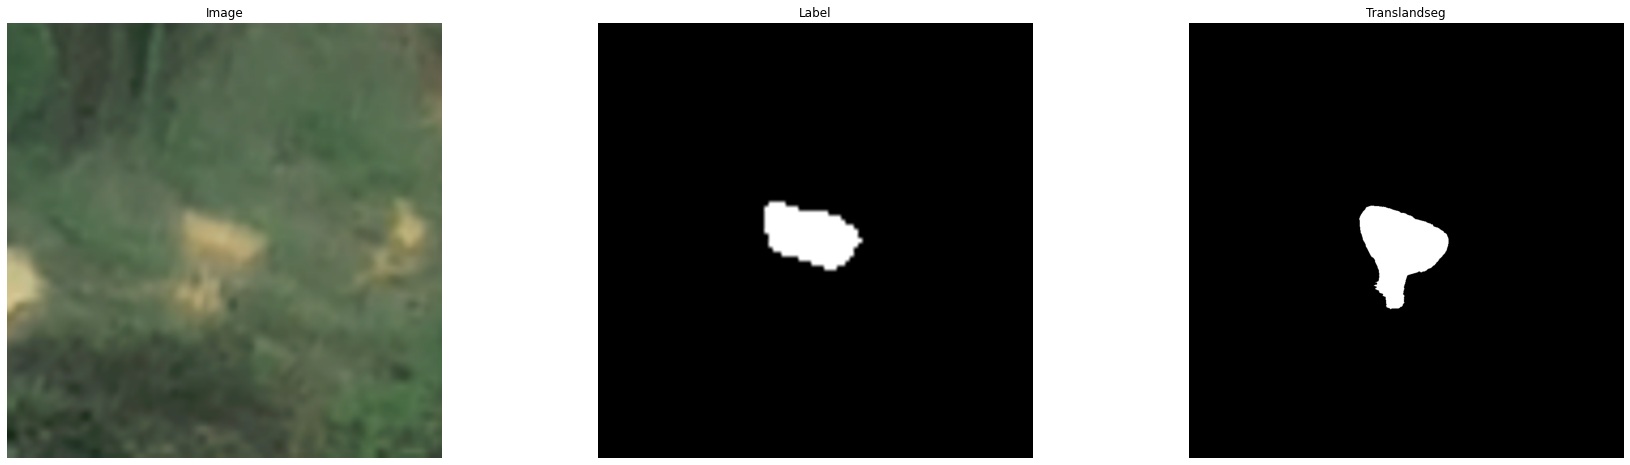

ny015.png


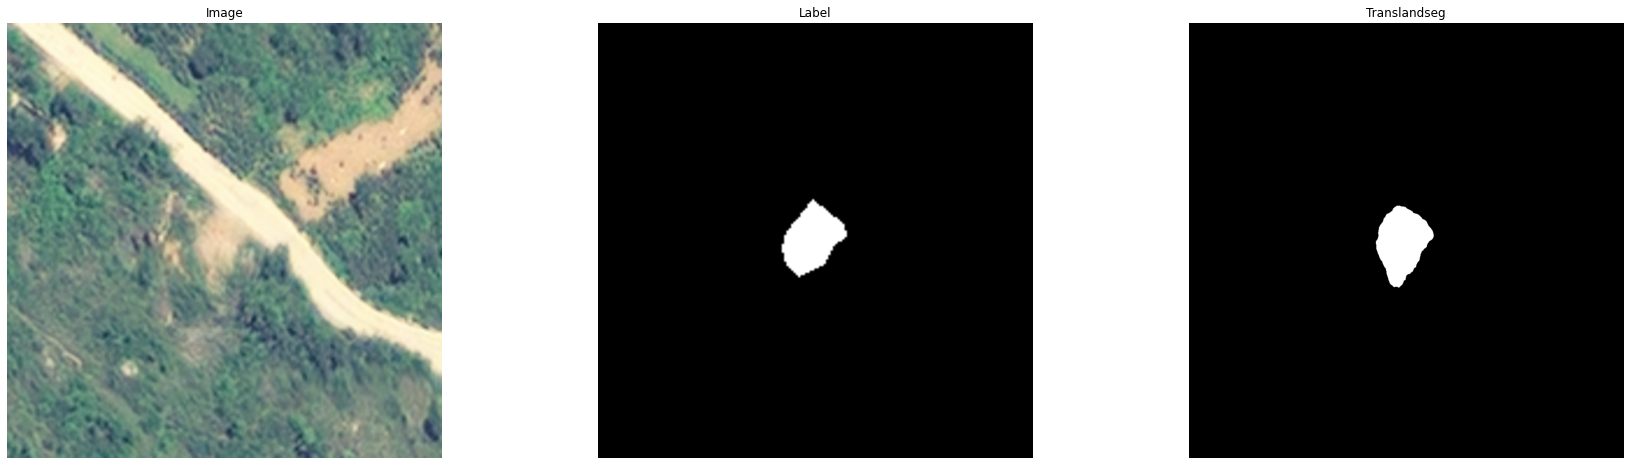

df030.png


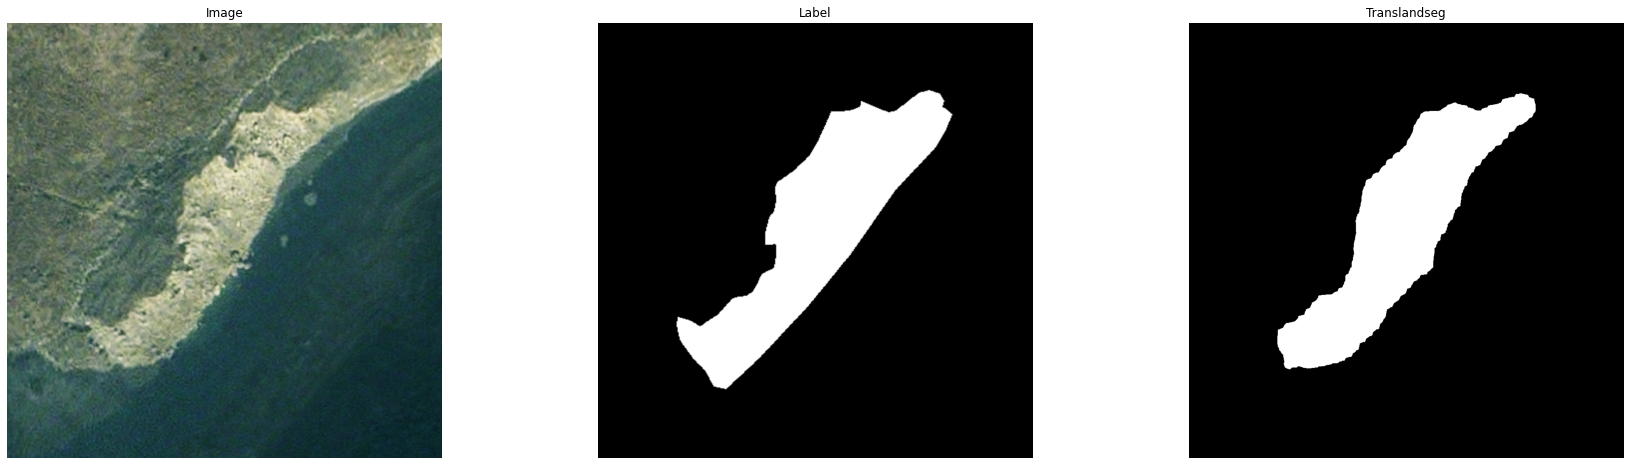

qx004.png


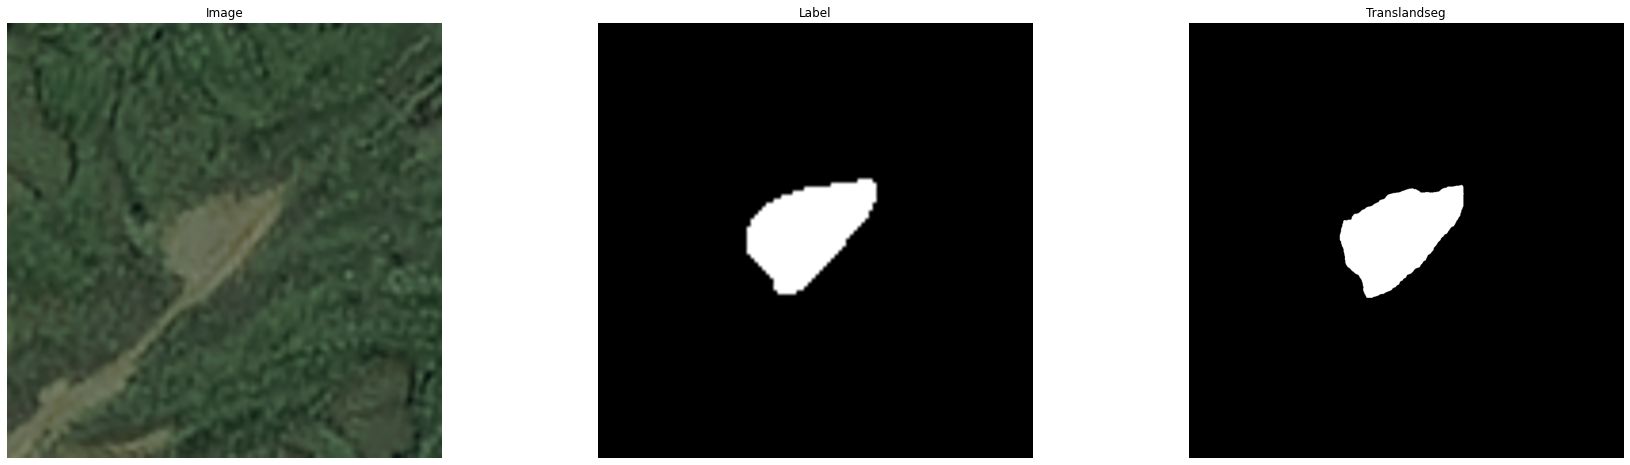

zj063.png


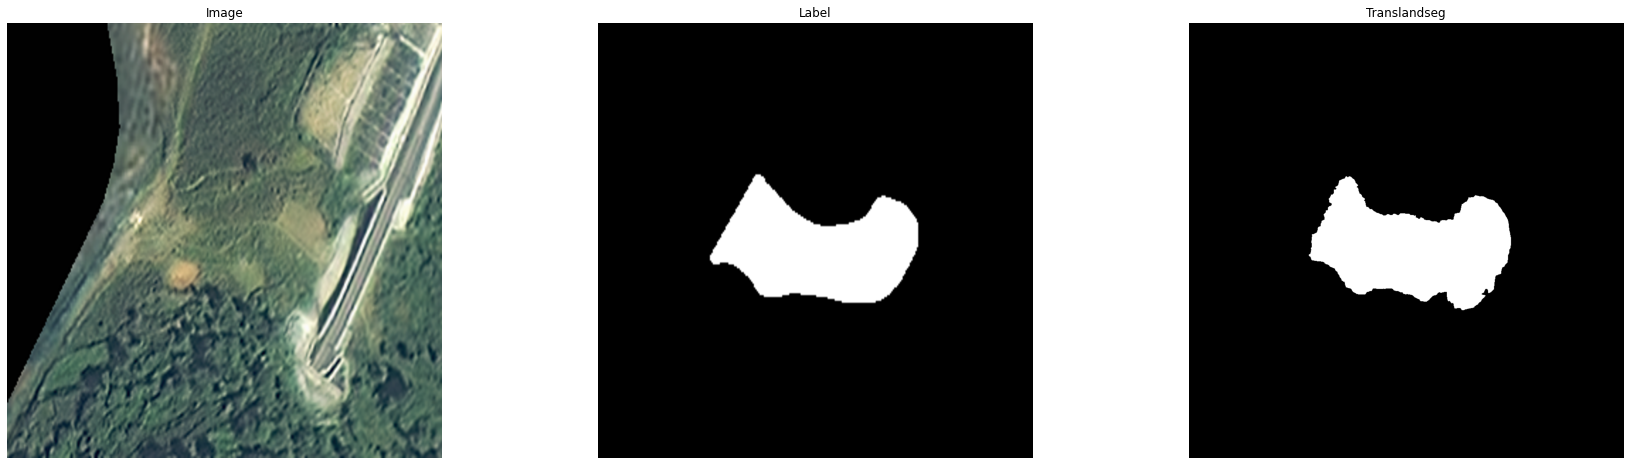

In [9]:
image_path = args.data_path_img
label_path = args.data_path_label

for index, name in enumerate(os.listdir(image_path)):
    if name.endswith('.png'):
        print(name)
        file_path = os.path.join(image_path, name)
        image = Image.open(file_path)
        image = image.resize((1024,1024))
        result = predict(model, image)
        image = np.array(image)
        label = Image.open(os.path.join(label_path, name[:-4]+'.png'))
        label = np.array(label.resize((1024,1024)))
        need_contrast = [image,label,result]
        title_list=['Image', 'Label', 'Translandseg']
        plot_contrast(need_contrast,title_list)
    if index > 20:
        break
